In [73]:
#import pandas_profiling
import datetime
from datetime import timedelta
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
import json
import numpy as np
from scipy import stats

# Style settings for the website Transparent white text for display on black background
rc={'figure.figsize':(11.7,8.27),
    'text.color':'white',
    'axes.labelcolor':'white',
    'xtick.color':'white',
    'ytick.color':'white'}

pollutant = 'Nitrogen dioxide (NO2)'

In [25]:
## Import files:

earthquake_df = pd.read_csv('usgs_mag5_1990_2019.csv')
aqs_df = pd.read_csv('final_aq.csv')

In [26]:
#We have a large enoug N to drop the NA measurements 
aqs_df.dropna()

,Unnamed: 0,q_ueid,Parameter,P_id,Station,Date,County,Measurement,Unit
0,0,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.9,Parts per million
1,1,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
2,2,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
3,3,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
5,5,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.9,Parts per million
...,...,...,...,...,...,...,...,...,...
1478835,1478835,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,19.0,Parts per billion
1478836,1478836,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,23.0,Parts per billion
1478837,1478837,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,15.0,Parts per billion
1478838,1478838,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,6.0,Parts per billion


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


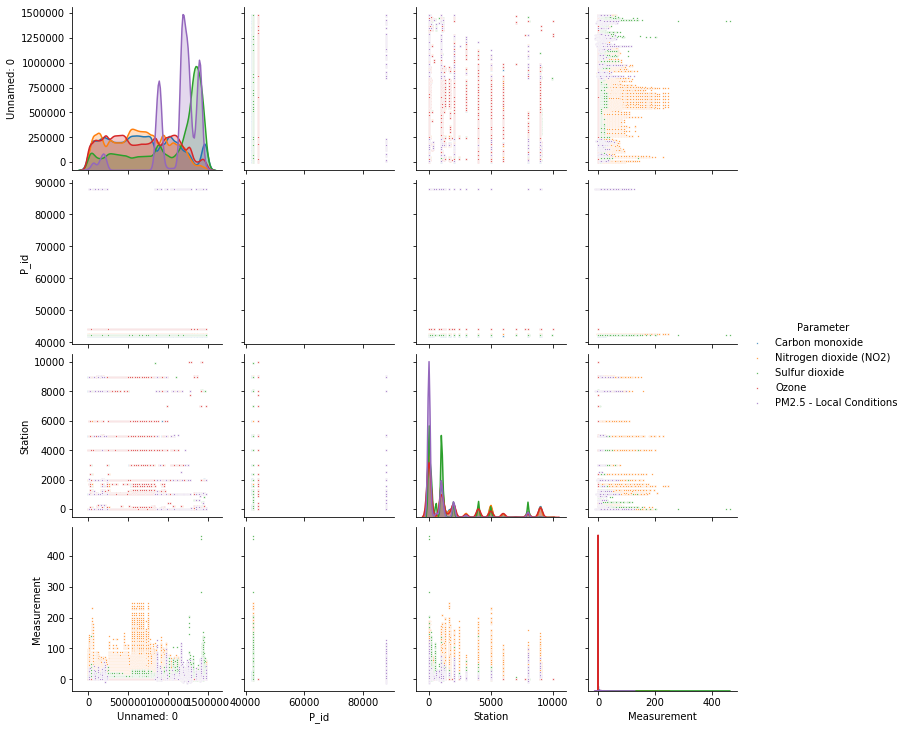

In [4]:
#sns.pairplot(data=aqs_df, hue = 'Parameter', plot_kws={'s':3})

In [5]:
# I need to figure out a way to calculate the day distance to the even from each measurement:
# event_date - measurement date = time_delta could be a time delta or an integer but just day. 15 bins [-7,-6,...,-1,0,1,...6,7]
#earthquake_df = earthquake_df.drop(index='Unnamed: 0')
aqs_df.keys()

Index(['Unnamed: 0', 'q_ueid', 'Parameter', 'P_id', 'Station', 'Date',
       'County', 'Measurement', 'Unit'],
      dtype='object')

In [74]:
event_date = earthquake_df[['Identifier', 'Date']]
aqs_df = aqs_df.rename(columns={'q_ueid':'Identifier'})
master_record = aqs_df.merge(earthquake_df, on='Identifier', suffixes=('_measure', '_event'))

# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f
master_record['Date_measure'] = pd.to_datetime(master_record['Date_measure'])
master_record['Date_event'] = pd.to_datetime(master_record['Date_event'], format='%Y%m%d')
master_record['time_bins'] =(master_record['Date_measure']-master_record['Date_event']).dt.days
clean_record = master_record[['Parameter','Measurement', 'Unit', 'Station', 'County', 'Location', 'GCS', 'Depth', 'Magnitude', 'Date_measure', 'Date_event', 'time_bins']]
pollutant_list = clean_record['Parameter'].unique().tolist()
pollutant_list

['Carbon monoxide',
 'Nitrogen dioxide (NO2)',
 'Sulfur dioxide',
 'Ozone',
 'PM2.5 - Local Conditions']

In [75]:
clean_record.to_csv('final_epa_usgs_df.csv')

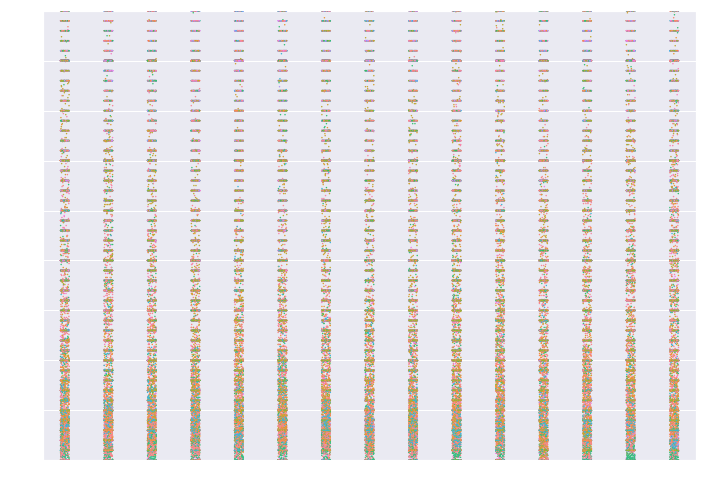

In [82]:
#Iterate over this to make graphs for each pollutant:
sns.set(rc=rc)
ax = sns.stripplot(x=clean_record['time_bins'], y = clean_record['Measurement'], hue=clean_record['Station'], data = clean_record[clean_record['Parameter'] == pollutant], marker='.', s=3, )
ax.set(ylim=(0, 45))
ax.legend().set_visible(False)

plt.pyplot.savefig(f'{pollutant}_jitterplo.png', format='png', transparent=True)


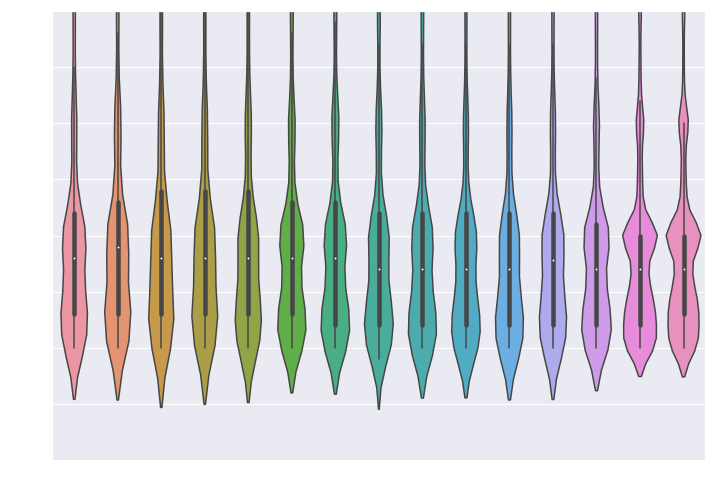

In [65]:
#g = sns.FacetGrid(clean_record, col='Parameter', hue='Unit', col_wrap=5)
sns.set(rc=rc)
#Iterate over this to make graphs for each pollutant:
ax = sns.violinplot(x=clean_record['time_bins'], y = clean_record['Measurement'], data = clean_record[clean_record['Parameter'] == pollutant], marker='.', s=1, aspect=1.75)
ax.set(ylim=(-1, 3))
plt.pyplot.savefig(f'{pollutant}_violinplot.svg', format='svg', transparent=True)

In [77]:
clean_record.to_csv('final_epa_usgs_df.csv')

In [78]:
clean_record = clean_record[clean_record['Parameter']==f'{pollutant}']

In [79]:
#List of data by days:
clean_record = clean_record.dropna()
bins = clean_record['time_bins'].unique().tolist()
bin_breakdown = [clean_record[clean_record['time_bins']==x] for x in bins]
len(bin_breakdown)
index = 0
ks_stat_dic = {}
# This calculates a pairwise kolmogorov smirnov test matrix for use in a heat map later
for dep_var in bins:
    for ind_var in bins:
        cutoff= min(len(bin_breakdown[dep_var]['Measurement']),len(bin_breakdown[ind_var]['Measurement']))
        ks_stat, tt_pv = stats.ks_2samp(bin_breakdown[dep_var]["Measurement"].sample(n=cutoff), bin_breakdown[ind_var]["Measurement"].sample(n=cutoff))
        ks_stat_dic[str(index)] =  {'Bin_1': dep_var,
                               'Bin_2': ind_var, 
                               'KS Stat': ks_stat,
                               'TT p-val':tt_pv}
        #status = f'{ind_var} vs: {dep_var}: KS Stat: {np.round(ks_stat, decimals=6)}, Two Taile p-value: {np.round(tt_pv, decimals=5)}'
        index +=1
        #print(index)
#ks_stat_dic

In [80]:
## Calculating the Kolmogorov Smirnov Matrix
ks_matrix = pd.DataFrame.from_dict(ks_stat_dic)
ks_matrix = ks_matrix.T
ks_matrix = ks_matrix.pivot('Bin_1', 'Bin_2', 'KS Stat')
ks_matrix



Bin_2,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Bin_1,,,,,,,,,,,,,,,
-7.0,-0.000000,0.027354,0.030443,0.019511,0.043679,0.076082,0.077798,0.037306,0.045198,0.043286,0.030737,0.036423,0.026766,0.015491,0.015382
-6.0,0.026080,-0.000000,0.017037,0.017422,0.051882,0.083309,0.085956,0.043893,0.037058,0.026615,0.025123,0.032727,0.031861,0.027136,0.040801
-5.0,0.031913,0.017711,-0.000000,0.016710,0.049276,0.081700,0.084738,0.043233,0.039381,0.028799,0.029019,0.038249,0.037396,0.032631,0.035957
-4.0,0.018922,0.017374,0.016663,-0.000000,0.035816,0.075663,0.080787,0.029827,0.029860,0.025819,0.020857,0.024990,0.023684,0.018942,0.032411
-3.0,0.044512,0.052026,0.049134,0.035674,-0.000000,0.041392,0.046071,0.027529,0.049623,0.057407,0.051451,0.050172,0.042430,0.038126,0.042549
-2.0,0.076278,0.083694,0.081747,0.075521,0.041534,-0.000000,0.011535,0.062479,0.074915,0.095774,0.091208,0.085320,0.077093,0.073794,0.075110
-1.0,0.078239,0.085571,0.084548,0.080787,0.046023,0.011630,-0.000000,0.067458,0.083377,0.098755,0.097461,0.092760,0.084764,0.077794,0.076858
0.0,0.037894,0.044181,0.043424,0.029684,0.028008,0.062479,0.067650,-0.000000,0.034380,0.044714,0.037583,0.036291,0.021239,0.031474,0.035807
1.0,0.045002,0.037058,0.038948,0.029668,0.049334,0.074963,0.083329,0.034236,-0.000000,0.032312,0.025677,0.027600,0.031880,0.033210,0.056632


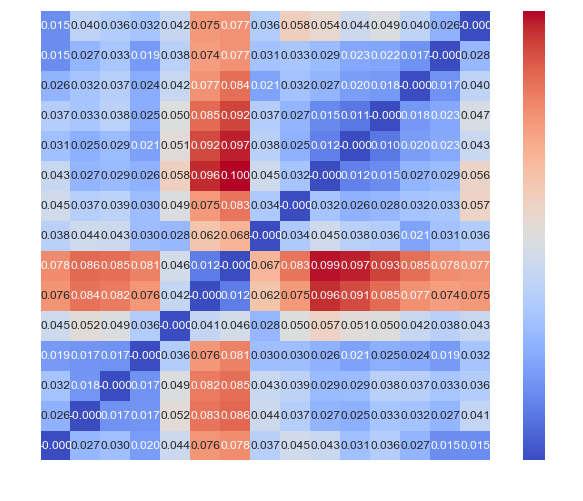

In [81]:
r = sns.heatmap(data=ks_matrix, cmap='coolwarm', square=True, robust=True, annot=True, fmt='.3f', vmin=0, vmax=0.1)
r.set_ylim(0,15)
r.set_xlim(0,15)
plt.pyplot.savefig(f'{pollutant}_ks_plot.svg', format='svg')